<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Centro_Universitario_del_Guadalajara_Logo.png/640px-Centro_Universitario_del_Guadalajara_Logo.png" alt="Drawing" style="width: 600px;"/>
</center>
    
<center> <span style="color:DarkBlue">  Tema 12: Clustering Jerárquico, Matriz de distancias e implementación manual</span>  </center>
<center> <span style="color:Blue"> M. en C. Iván A. Toledano Juárez </span>  </center>

## Introducción

En este notebook exploramos el **clustering jerárquico**, un método no supervisado que agrupa observaciones en función de su similitud. Este tipo de clustering no requiere especificar el número de grupos previamente, sino que construye una jerarquía de fusiones o divisiones entre observaciones.

Comenzaremos analizando una matriz de valoraciones de películas para un conjunto de usuarios. A partir de estas valoraciones, construiremos una **matriz de distancias** que cuantifica la similitud o disimilitud entre los usuarios, para posteriormente aplicar el método jerárquico y visualizar el dendrograma resultante.

In [89]:
from scipy.spatial import distance_matrix ## calcular distancias con scipy
from scipy.cluster.hierarchy import dendrogram, linkage # hacer clustering jerarquico con scipy, graficos con dendrogram
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

### Carga de datos

El dataset contiene las valoraciones de 10 usuarios sobre 3 películas.  
Cada columna (excepto el identificador del usuario) representa una película, y cada valor numérico indica la calificación asignada por ese usuario.

Para el análisis de similitud, eliminamos la columna de identificación, ya que no aporta información sobre las distancias en el espacio de las valoraciones.


In [29]:
mainpath = "../data"
filename = "movies/movies.csv"
fullpath = os.path.join(mainpath,filename)

data = pd.read_csv(fullpath, sep = ';')
data
#vemos que esta bien cargado con el separados
## solo tenemos diez usuarios

,user_id,star_wars,lord_of_the_rings,harry_potter
0,1,1.2,4.9,2.1
1,2,2.1,8.1,7.9
2,3,7.4,3.0,9.9
3,4,5.6,0.5,1.8
4,5,1.5,8.3,2.6
5,6,2.5,3.7,6.5
6,7,2.0,8.2,8.5
7,8,1.8,9.3,4.5
8,9,2.6,1.7,3.1
9,10,1.5,4.7,2.3


Tenemos 10 usuarios, cuyo id está en la primera columna. Tenemos 3 películas con su correspondiente valoración que le otorgó cada usuario. Cómo sólo quiero la distancia entre las valoraciones, la columna de ID no es necesaria.

In [30]:
## guardamos una lista de las columnas que nos interesan
movies = data.columns.values.tolist()[1:] # de la primera en adelante
movies

['star_wars', 'lord_of_the_rings', 'harry_potter']

En este caso no haría falta normalizar, pues todos las valoraciones se supone que están entre 1 y 10, el mismo rango entre todas.

### Cálculo de la matriz de distancias

La **matriz de distancias** cuantifica cuán diferentes son las observaciones entre sí. Cada elemento $d_{ij}$ representa la distancia entre las observaciones $i$ y $j$, medida a partir de sus valoraciones o características numéricas.

Si representamos cada observación como un vector $x_i = (x_{i1}, x_{i2}, \dots, x_{ip})$, con $p$ características, entonces la distancia entre dos observaciones $x_i$ y $x_j$ puede calcularse de diversas formas según la métrica elegida.

#### 1. Distancia euclidiana
Es la métrica más común y se define como:

\begin{equation}
d_{\text{euclidiana}}(x_i, x_j) = \sqrt{ \sum_{k=1}^{p} (x_{ik} - x_{jk})^2 }
\end{equation}

Esta medida corresponde a la longitud del segmento recto que une los puntos $x_i$ y $x_j$ en el espacio $p$-dimensional.

#### 2. Distancia de Manhattan (o $L_1$)
Mide la distancia total recorrida si uno solo puede moverse en ejes perpendiculares:

\begin{equation}
d_{\text{manhattan}}(x_i, x_j) = \sum_{k=1}^{p} |x_{ik} - x_{jk}|
\end{equation}

Es menos sensible a valores atípicos que la euclidiana, y resulta útil cuando las diferencias absolutas son más interpretables que las cuadráticas.

#### 3. Distancia de Minkowski (generalización)
Es una forma general que incluye a las dos anteriores como casos particulares:

\begin{equation}
d_{\text{minkowski}}(x_i, x_j) = \left( \sum_{k=1}^{p} |x_{ik} - x_{jk}|^r \right)^{1/r}
\end{equation}

donde:
- $r = 1$ produce la distancia de Manhattan,  
- $r = 2$ produce la distancia euclidiana.

En este notebook utilizaremos principalmente la **distancia euclidiana**, implementada mediante la función `distance_matrix` de `scipy.spatial`.  Esta función puede aceptar diferentes métricas según el parámetro `metric`, lo que permite comparar los resultados obtenidos bajo distintas medidas de similitud.

In [97]:
# Calculamos la matriz de distancias 
dd1 = distance_matrix(data[movies], data[movies], p=1) # Distancia de Manhattan
dd2 = distance_matrix(data[movies], data[movies], p=2) # Distancia Euclídea
dd10 = distance_matrix(data[movies], data[movies], p=10) # Distancia de Minkowski para p=10 

In [98]:
dd1
# los objetos son arrays

array([[ 0. ,  9.9, 15.9,  9.1,  4.2,  6.9, 10.5,  7.4,  5.6,  0.7],
       [ 9.9,  0. , 12.4, 17.2,  6.1,  6.2,  0.8,  4.9, 11.7,  9.6],
       [15.9, 12.4,  0. , 12.4, 18.5,  9. , 12. , 17.3, 12.9, 15.2],
       [ 9.1, 17.2, 12.4,  0. , 12.7, 11. , 18. , 15.3,  5.5,  8.8],
       [ 4.2,  6.1, 18.5, 12.7,  0. ,  9.5,  6.5,  3.2,  8.2,  3.9],
       [ 6.9,  6.2,  9. , 11. ,  9.5,  0. ,  7. ,  8.3,  5.5,  6.2],
       [10.5,  0.8, 12. , 18. ,  6.5,  7. ,  0. ,  5.3, 12.5, 10.2],
       [ 7.4,  4.9, 17.3, 15.3,  3.2,  8.3,  5.3,  0. ,  9.8,  7.1],
       [ 5.6, 11.7, 12.9,  5.5,  8.2,  5.5, 12.5,  9.8,  0. ,  4.9],
       [ 0.7,  9.6, 15.2,  8.8,  3.9,  6.2, 10.2,  7.1,  4.9,  0. ]])

In [99]:
# Mejor lo ponemos como dataframes
# Para que visualmente se vean mejor
# Hacemos una función para esto

def dm_to_df(dd, col_name):
    import pandas as pd
    return pd.DataFrame(dd,index=col_name, columns=col_name) # Estoy comparando los objetos col name consigo mismo (el índice es el mismo que las columnas)


In [100]:
# visualizo como dataframe la matriz de distancias de los user ID
dm_to_df(dd1, data["user_id"])

user_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,0.0,9.9,15.9,9.1,4.2,6.9,10.5,7.4,5.6,0.7
2,9.9,0.0,12.4,17.2,6.1,6.2,0.8,4.9,11.7,9.6
3,15.9,12.4,0.0,12.4,18.5,9.0,12.0,17.3,12.9,15.2
4,9.1,17.2,12.4,0.0,12.7,11.0,18.0,15.3,5.5,8.8
5,4.2,6.1,18.5,12.7,0.0,9.5,6.5,3.2,8.2,3.9
6,6.9,6.2,9.0,11.0,9.5,0.0,7.0,8.3,5.5,6.2
7,10.5,0.8,12.0,18.0,6.5,7.0,0.0,5.3,12.5,10.2
8,7.4,4.9,17.3,15.3,3.2,8.3,5.3,0.0,9.8,7.1
9,5.6,11.7,12.9,5.5,8.2,5.5,12.5,9.8,0.0,4.9


In [101]:
dm_to_df(dd2, data["user_id"])

user_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,0.000000,6.685058,10.143471,6.229767,3.449638,4.742362,7.244998,5.047772,3.633180,0.412311
2,6.685058,0.000000,7.622336,10.354709,5.337602,4.634652,0.616441,3.618011,8.015610,6.578754
3,10.143471,7.622336,0.000000,8.666026,10.779147,6.004998,7.626270,10.010494,8.424369,9.770363
4,6.229767,10.354709,8.666026,0.000000,8.848164,6.476110,10.823123,9.958414,3.482815,5.890671
5,3.449638,5.337602,10.779147,8.848164,0.000000,6.113101,5.921993,2.167948,6.709694,3.612478
6,4.742362,4.634652,6.004998,6.476110,6.113101,0.000000,4.949747,5.987487,3.945884,4.431704
7,7.244998,0.616441,7.626270,10.823123,5.921993,4.949747,0.000000,4.153312,8.471718,7.137226
8,5.047772,3.618011,10.010494,9.958414,2.167948,5.987487,4.153312,0.000000,7.769170,5.107837
9,3.633180,8.015610,8.424369,3.482815,6.709694,3.945884,8.471718,7.769170,0.000000,3.293934


In [102]:
dm_to_df(dd10, data["user_id"])

user_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,0.000000,5.801514,7.875189,4.715803,3.400000,4.400003,6.400850,4.401025,3.200085,0.301025
2,5.801514,0.000000,5.582463,7.680689,5.300000,4.400005,0.600000,3.400010,6.435159,5.603800
3,7.875189,5.582463,0.000000,8.100007,7.408914,4.912532,5.689450,6.570254,6.820602,7.658364
4,4.715803,7.680689,8.100007,0.000000,7.801255,4.717102,7.873307,8.800205,3.000101,4.450759
5,3.400000,5.300000,7.408914,7.801255,0.000000,4.681464,5.900000,1.900310,6.600000,3.600000
6,4.400003,4.400005,4.912532,4.717102,4.681464,0.000000,4.500135,5.600019,3.401683,4.200000
7,6.400850,0.600000,5.689450,7.873307,5.900000,4.500135,0.000000,4.000001,6.595259,6.202035
8,4.401025,3.400010,6.570254,8.800205,1.900310,5.600019,4.000001,0.000000,7.600000,4.600288
9,3.200085,6.435159,6.820602,3.000101,6.600000,3.401683,6.595259,7.600000,0.000000,3.000014


Vemos como difieren las distancias entre pares de usuarios. Para verlo de forma visual podemos utilizar la siguiente paquetería.

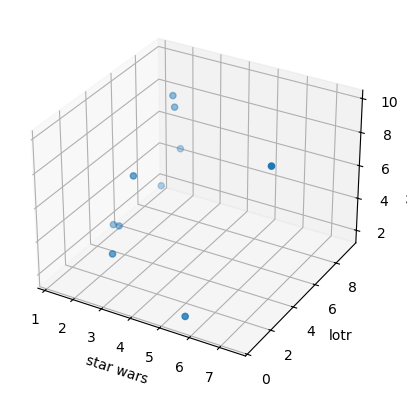

In [103]:
fig = plt.figure() # creamos una figura vacia

ax = fig.add_subplot(111,projection='3d') # Utilizamos la proyección 3d

ax.scatter(xs=data["star_wars"], ys=data["lord_of_the_rings"],zs=data["harry_potter"]) # agregamos los puntos
ax.set_xlabel("star wars")
ax.set_ylabel("lotr")
ax.set_zlabel("Harry Potter")
plt.show()

Se ve por ahí un valor atípico

### Implementación manual del clustering jerárquico

Para comprender el algoritmo en detalle, implementaremos de forma manual los pasos del clustering jerárquico.  El procedimiento básico consiste en:

1. Calcular la matriz de distancias inicial.  
2. Identificar los dos elementos (o grupos) más cercanos.  
3. Fusionarlos en un nuevo grupo.  
4. Recalcular las distancias entre este nuevo grupo y los restantes.  
5. Repetir los pasos 2–4 hasta que quede un solo grupo.

Este proceso se puede representar mediante una matriz de distancias que se actualiza en cada iteración, eliminando las filas y columnas correspondientes a los grupos fusionados.

In [104]:
# Convertimos a data frame
df = dm_to_df(dd1, data['user_id'])
df

user_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,0.0,9.9,15.9,9.1,4.2,6.9,10.5,7.4,5.6,0.7
2,9.9,0.0,12.4,17.2,6.1,6.2,0.8,4.9,11.7,9.6
3,15.9,12.4,0.0,12.4,18.5,9.0,12.0,17.3,12.9,15.2
4,9.1,17.2,12.4,0.0,12.7,11.0,18.0,15.3,5.5,8.8
5,4.2,6.1,18.5,12.7,0.0,9.5,6.5,3.2,8.2,3.9
6,6.9,6.2,9.0,11.0,9.5,0.0,7.0,8.3,5.5,6.2
7,10.5,0.8,12.0,18.0,6.5,7.0,0.0,5.3,12.5,10.2
8,7.4,4.9,17.3,15.3,3.2,8.3,5.3,0.0,9.8,7.1
9,5.6,11.7,12.9,5.5,8.2,5.5,12.5,9.8,0.0,4.9


In [105]:
# se hace a mano el clustering (eleccion de elementos que mas se parecen a base de una distancia)
# ponemos una matriz z vacia, añadiendo que grupos he unido y a qué distancia

Z = []

In [106]:
# Vemos cual es la distancia más pequeña
# Vemos que es la fila 1 con la columna 10 (o sea la 11 en python)

df[11] = df[1] + df[10] # sumar por columnas y por filas
df.loc[11] = df.loc[1] + df.loc[10] # sumar por filas

# Se uno el elemento 1 con el elemento 10 con una distancia de 0.7, con un nuevo cluster de 2 elementos
Z.append([1,10,0.7,2]) # id1, id2, d, n elementos en el cluster -> observacion numero 11

df

user_id,1,2,3,4,5,6,7,8,9,10,11
user_id,,,,,,,,,,,
1,0.0,9.9,15.9,9.1,4.2,6.9,10.5,7.4,5.6,0.7,0.7
2,9.9,0.0,12.4,17.2,6.1,6.2,0.8,4.9,11.7,9.6,19.5
3,15.9,12.4,0.0,12.4,18.5,9.0,12.0,17.3,12.9,15.2,31.1
4,9.1,17.2,12.4,0.0,12.7,11.0,18.0,15.3,5.5,8.8,17.9
5,4.2,6.1,18.5,12.7,0.0,9.5,6.5,3.2,8.2,3.9,8.1
6,6.9,6.2,9.0,11.0,9.5,0.0,7.0,8.3,5.5,6.2,13.1
7,10.5,0.8,12.0,18.0,6.5,7.0,0.0,5.3,12.5,10.2,20.7
8,7.4,4.9,17.3,15.3,3.2,8.3,5.3,0.0,9.8,7.1,14.5
9,5.6,11.7,12.9,5.5,8.2,5.5,12.5,9.8,0.0,4.9,10.5


In [107]:
# Ahora hay que recalcular la distancia a todos y cada uno de los puntos
# se reemplaza los valore en la fila 11 con el menor de las distancias entre la fila 1 y la fila 10

for i in df.columns.values.tolist():
    df.loc[11,i] = min(df.loc[1,i], df.loc[10,i])
    df.loc[i,11] = min(df.loc[i,1], df.loc[i,10])
df

user_id,1,2,3,4,5,6,7,8,9,10,11
user_id,,,,,,,,,,,
1,0.0,9.9,15.9,9.1,4.2,6.9,10.5,7.4,5.6,0.7,0.0
2,9.9,0.0,12.4,17.2,6.1,6.2,0.8,4.9,11.7,9.6,9.6
3,15.9,12.4,0.0,12.4,18.5,9.0,12.0,17.3,12.9,15.2,15.2
4,9.1,17.2,12.4,0.0,12.7,11.0,18.0,15.3,5.5,8.8,8.8
5,4.2,6.1,18.5,12.7,0.0,9.5,6.5,3.2,8.2,3.9,3.9
6,6.9,6.2,9.0,11.0,9.5,0.0,7.0,8.3,5.5,6.2,6.2
7,10.5,0.8,12.0,18.0,6.5,7.0,0.0,5.3,12.5,10.2,10.2
8,7.4,4.9,17.3,15.3,3.2,8.3,5.3,0.0,9.8,7.1,7.1
9,5.6,11.7,12.9,5.5,8.2,5.5,12.5,9.8,0.0,4.9,4.9


In [108]:
# Haciendo esto, ya hay dos elementos 1 y 10 que ya no nos sirven, pues fueron agrupados
df  = df.drop([1,10]) # por columna
df = df.drop([1,10], axis=1)
df

user_id,2,3,4,5,6,7,8,9,11
user_id,,,,,,,,,
2,0.0,12.4,17.2,6.1,6.2,0.8,4.9,11.7,9.6
3,12.4,0.0,12.4,18.5,9.0,12.0,17.3,12.9,15.2
4,17.2,12.4,0.0,12.7,11.0,18.0,15.3,5.5,8.8
5,6.1,18.5,12.7,0.0,9.5,6.5,3.2,8.2,3.9
6,6.2,9.0,11.0,9.5,0.0,7.0,8.3,5.5,6.2
7,0.8,12.0,18.0,6.5,7.0,0.0,5.3,12.5,10.2
8,4.9,17.3,15.3,3.2,8.3,5.3,0.0,9.8,7.1
9,11.7,12.9,5.5,8.2,5.5,12.5,9.8,0.0,4.9
11,9.6,15.2,8.8,3.9,6.2,10.2,7.1,4.9,0.0


Juntamos todo el código en una sola instrucción

In [109]:
#df[11] = df[1]+df[10]
#df.loc[11] = df.loc[1] + df.loc[10]
#Z.append([1,10,0.7,2])

#for i in df.columns.values.tolist():
#    df.loc[11,i] = min(df.loc[1,i], df.loc[10,i])
#    df.loc[i,11] = min(df.loc[i,1], df.loc[i,10])
    
#df  = df.drop([1,10])
#df = df.drop([1,10], axis=1)
#df

In [110]:
# Estos son los siguientes elementos con distancia minima de 0.8
x = 2
y = 7

n = 12

df[n]=df[x]+df[y]
df.loc[n] = df.loc[x] + df.loc[y]
Z.append([x,y,df.loc[x][y],2])

for i in df.columns.values.tolist():
    df.loc[n,i] = min(df.loc[x,i], df.loc[y,i])
    df.loc[i,n] = min(df.loc[i,x], df.loc[i,y])
    
df  = df.drop([x,y])
df = df.drop([x,y], axis=1)
df

user_id,3,4,5,6,8,9,11,12
user_id,,,,,,,,
3,0.0,12.4,18.5,9.0,17.3,12.9,15.2,12.0
4,12.4,0.0,12.7,11.0,15.3,5.5,8.8,17.2
5,18.5,12.7,0.0,9.5,3.2,8.2,3.9,6.1
6,9.0,11.0,9.5,0.0,8.3,5.5,6.2,6.2
8,17.3,15.3,3.2,8.3,0.0,9.8,7.1,4.9
9,12.9,5.5,8.2,5.5,9.8,0.0,4.9,11.7
11,15.2,8.8,3.9,6.2,7.1,4.9,0.0,9.6
12,12.0,17.2,6.1,6.2,4.9,11.7,9.6,0.0


In [111]:
# Le echamos un ojo a la Z
Z

[[1, 10, 0.7, 2], [2, 7, np.float64(0.7999999999999994), 2]]

Seguimos con lo mismo

In [112]:
x = 5
y = 8

n = 13

df[n]=df[x]+df[y]
df.loc[n] = df.loc[x] + df.loc[y]
Z.append([x,y,df.loc[x][y],2]) # siguen siendo dos elementos nuevos

for i in df.columns.values.tolist():
    df.loc[n,i] = min(df.loc[x,i], df.loc[y,i])
    df.loc[i,n] = min(df.loc[i,x], df.loc[i,y])
    
df  = df.drop([x,y])
df = df.drop([x,y], axis=1)
df

user_id,3,4,6,9,11,12,13
user_id,,,,,,,
3,0.0,12.4,9.0,12.9,15.2,12.0,17.3
4,12.4,0.0,11.0,5.5,8.8,17.2,12.7
6,9.0,11.0,0.0,5.5,6.2,6.2,8.3
9,12.9,5.5,5.5,0.0,4.9,11.7,8.2
11,15.2,8.8,6.2,4.9,0.0,9.6,3.9
12,12.0,17.2,6.2,11.7,9.6,0.0,4.9
13,17.3,12.7,8.3,8.2,3.9,4.9,0.0


In [113]:
x = 9
y = 4

n = 14

df[n]=df[x]+df[y]
df.loc[n] = df.loc[x] + df.loc[y]
Z.append([x,y,df.loc[x][y],2]) # siguen siendo dos elementos nuevos

for i in df.columns.values.tolist():
    df.loc[n,i] = min(df.loc[x,i], df.loc[y,i])
    df.loc[i,n] = min(df.loc[i,x], df.loc[i,y])
    
df  = df.drop([x,y])
df = df.drop([x,y], axis=1)
df

user_id,3,6,11,12,13,14
user_id,,,,,,
3,0.0,9.0,15.2,12.0,17.3,12.4
6,9.0,0.0,6.2,6.2,8.3,5.5
11,15.2,6.2,0.0,9.6,3.9,4.9
12,12.0,6.2,9.6,0.0,4.9,11.7
13,17.3,8.3,3.9,4.9,0.0,8.2
14,12.4,5.5,4.9,11.7,8.2,0.0


In [114]:
x = 6
y = 3

n = 15

df[n]=df[x]+df[y]
df.loc[n] = df.loc[x] + df.loc[y]
Z.append([x,y,df.loc[x][y],2]) # siguen siendo dos elementos nuevos

for i in df.columns.values.tolist():
    df.loc[n,i] = min(df.loc[x,i], df.loc[y,i])
    df.loc[i,n] = min(df.loc[i,x], df.loc[i,y])
    
df  = df.drop([x,y])
df = df.drop([x,y], axis=1)
df

user_id,11,12,13,14,15
user_id,,,,,
11,0.0,9.6,3.9,4.9,6.2
12,9.6,0.0,4.9,11.7,6.2
13,3.9,4.9,0.0,8.2,8.3
14,4.9,11.7,8.2,0.0,5.5
15,6.2,6.2,8.3,5.5,0.0


In [115]:
x = 11
y = 13 # ahora ya la distancia minima es entre el grupo 11 y 13,

n = 16

df[n]=df[x]+df[y]
df.loc[n] = df.loc[x] + df.loc[y]
Z.append([x,y,df.loc[x][y],4]) # ahora se están juntando clústers de 2 elementos cada uno

for i in df.columns.values.tolist():
    df.loc[n,i] = min(df.loc[x,i], df.loc[y,i])
    df.loc[i,n] = min(df.loc[i,x], df.loc[i,y])
    
df  = df.drop([x,y])
df = df.drop([x,y], axis=1)
df

user_id,12,14,15,16
user_id,,,,
12,0.0,11.7,6.2,4.9
14,11.7,0.0,5.5,4.9
15,6.2,5.5,0.0,6.2
16,4.9,4.9,6.2,0.0


In [116]:
Z

[[1, 10, 0.7, 2],
 [2, 7, np.float64(0.7999999999999994), 2],
 [5, 8, np.float64(3.2), 2],
 [9, 4, np.float64(5.499999999999999), 2],
 [6, 3, np.float64(9.0), 2],
 [11, 13, np.float64(3.900000000000001), 4]]

In [117]:
# en este caso aparece la distancia 4.9 dos veces, asi que seria una agrupacion de tres elementos
# cambian unas cosas

x = 12
y = 14 
z = 16

n = 17

df[n]=df[x]+df[y]
df.loc[n] = df.loc[x] + df.loc[y]
Z.append([(x,y,z),df.loc[x][y],7]) # ahora son tres clusters los que se están agrupando

for i in df.columns.values.tolist():
    df.loc[n,i] = min(df.loc[x,i], df.loc[y,i], df.loc[z,i])
    df.loc[i,n] = min(df.loc[i,x], df.loc[i,y], df.loc[i,z])
    
df  = df.drop([x,y,z])
df = df.drop([x,y,z], axis=1)
df

user_id,15,17
user_id,,
15,0.0,5.5
17,5.5,0.0


In [118]:
x = 15
y = 17 

n = 18

df[n]=df[x]+df[y]
df.loc[n] = df.loc[x] + df.loc[y]
Z.append([x,y,df.loc[x][y],10])

for i in df.columns.values.tolist():
    df.loc[n,i] = min(df.loc[x,i], df.loc[y,i])
    df.loc[i,n] = min(df.loc[i,x], df.loc[i,y])
    
df  = df.drop([x,y])
df = df.drop([x,y], axis=1)
df

user_id,18
user_id,
18,0.0


In [119]:
# En Z se guardan todas las uniones que hemos hecho
Z

[[1, 10, 0.7, 2],
 [2, 7, np.float64(0.7999999999999994), 2],
 [5, 8, np.float64(3.2), 2],
 [9, 4, np.float64(5.499999999999999), 2],
 [6, 3, np.float64(9.0), 2],
 [11, 13, np.float64(3.900000000000001), 4],
 [(12, 14, 16), np.float64(11.7), 7],
 [15, 17, np.float64(5.5), 10]]

### Clustering jerárquico (en python)

Una vez obtenida la matriz de distancias, aplicamos un método de **enlace jerárquico**.  Este proceso agrupa iterativamente las observaciones más cercanas, formando una estructura en árbol denominada **dendrograma**.

Cada tipo de enlace define cómo se calcula la distancia entre grupos:
- **Single linkage:** distancia mínima entre elementos de dos grupos.  
- **Complete linkage:** distancia máxima entre elementos de dos grupos.  
- **Average linkage:** promedio de todas las distancias entre elementos de ambos grupos.

El algoritmo de enlace se representa formalmente como:

\begin{equation}
D(A,B) =
\begin{cases}
\min_{i \in A, j \in B} d(i,j) & \text{(single)} \\
\max_{i \in A, j \in B} d(i,j) & \text{(complete)} \\
\frac{1}{|A||B|}\sum_{i \in A}\sum_{j \in B} d(i,j) & \text{(average)}
\end{cases}
\end{equation}


In [120]:
# Ya teniamos las columnas de las pelicuas
movies

['star_wars', 'lord_of_the_rings', 'harry_potter']

In [121]:
# Entonces teniamos la informacion de rating que cada usuario le daba a las peliculas
data[movies] # un filtrado para quitar el id

,star_wars,lord_of_the_rings,harry_potter
0,1.2,4.9,2.1
1,2.1,8.1,7.9
2,7.4,3.0,9.9
3,5.6,0.5,1.8
4,1.5,8.3,2.6
5,2.5,3.7,6.5
6,2.0,8.2,8.5
7,1.8,9.3,4.5
8,2.6,1.7,3.1
9,1.5,4.7,2.3


In [122]:
# la funcion linkage nos calcula el enlace del dataset que le pongamos, con el metodo que ingresemos
Z = linkage(data[movies], method="ward", metric="euclidean") # checar que los indices son a partir de 0, pero son los mismos que a mano
Z

array([[ 0.        ,  9.        ,  0.41231056,  2.        ],
       [ 1.        ,  6.        ,  0.6164414 ,  2.        ],
       [ 4.        ,  7.        ,  2.16794834,  2.        ],
       [ 3.        ,  8.        ,  3.48281495,  2.        ],
       [ 5.        , 10.        ,  5.2943366 ,  3.        ],
       [13.        , 14.        ,  6.59317829,  5.        ],
       [11.        , 12.        ,  6.66408283,  4.        ],
       [ 2.        , 15.        , 10.62355873,  6.        ],
       [16.        , 17.        , 12.8156935 , 10.        ]])

### Interpretación del dendrograma

El dendrograma muestra visualmente la secuencia de fusiones entre observaciones o grupos.  El eje vertical representa la **distancia de enlace**, es decir, el grado de disimilitud entre los grupos fusionados.

La altura a la que se unen dos ramas indica cuán similares son las observaciones correspondientes. Cortar el dendrograma a una altura determinada equivale a elegir un número de clústeres.


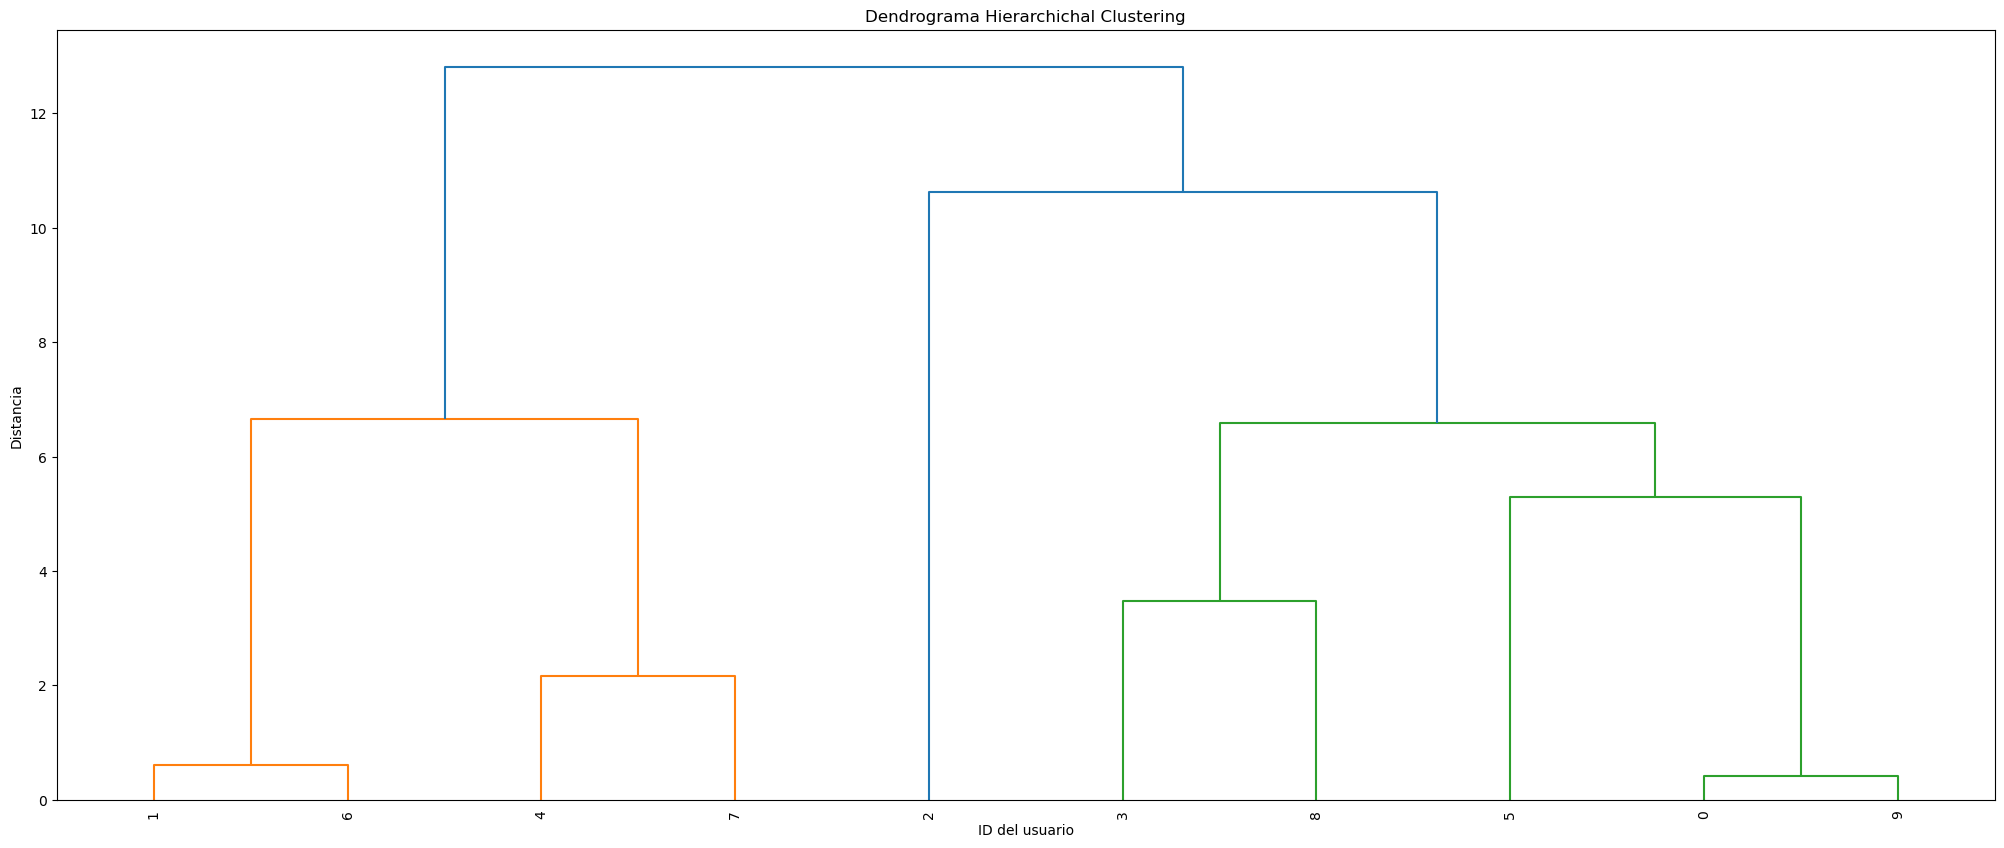

In [123]:
# podemos pintar un dendrograma

plt.figure(figsize=(25,10)) # para generar el tamaño de la figura
plt.title("Dendrograma Hierarchichal Clustering")
plt.xlabel("ID del usuario")
plt.ylabel("Distancia")
dendrogram(Z, leaf_rotation=90.0,leaf_font_size=10, orientation="top") # rotado 90 grados para leerlo horizontal
plt.show()

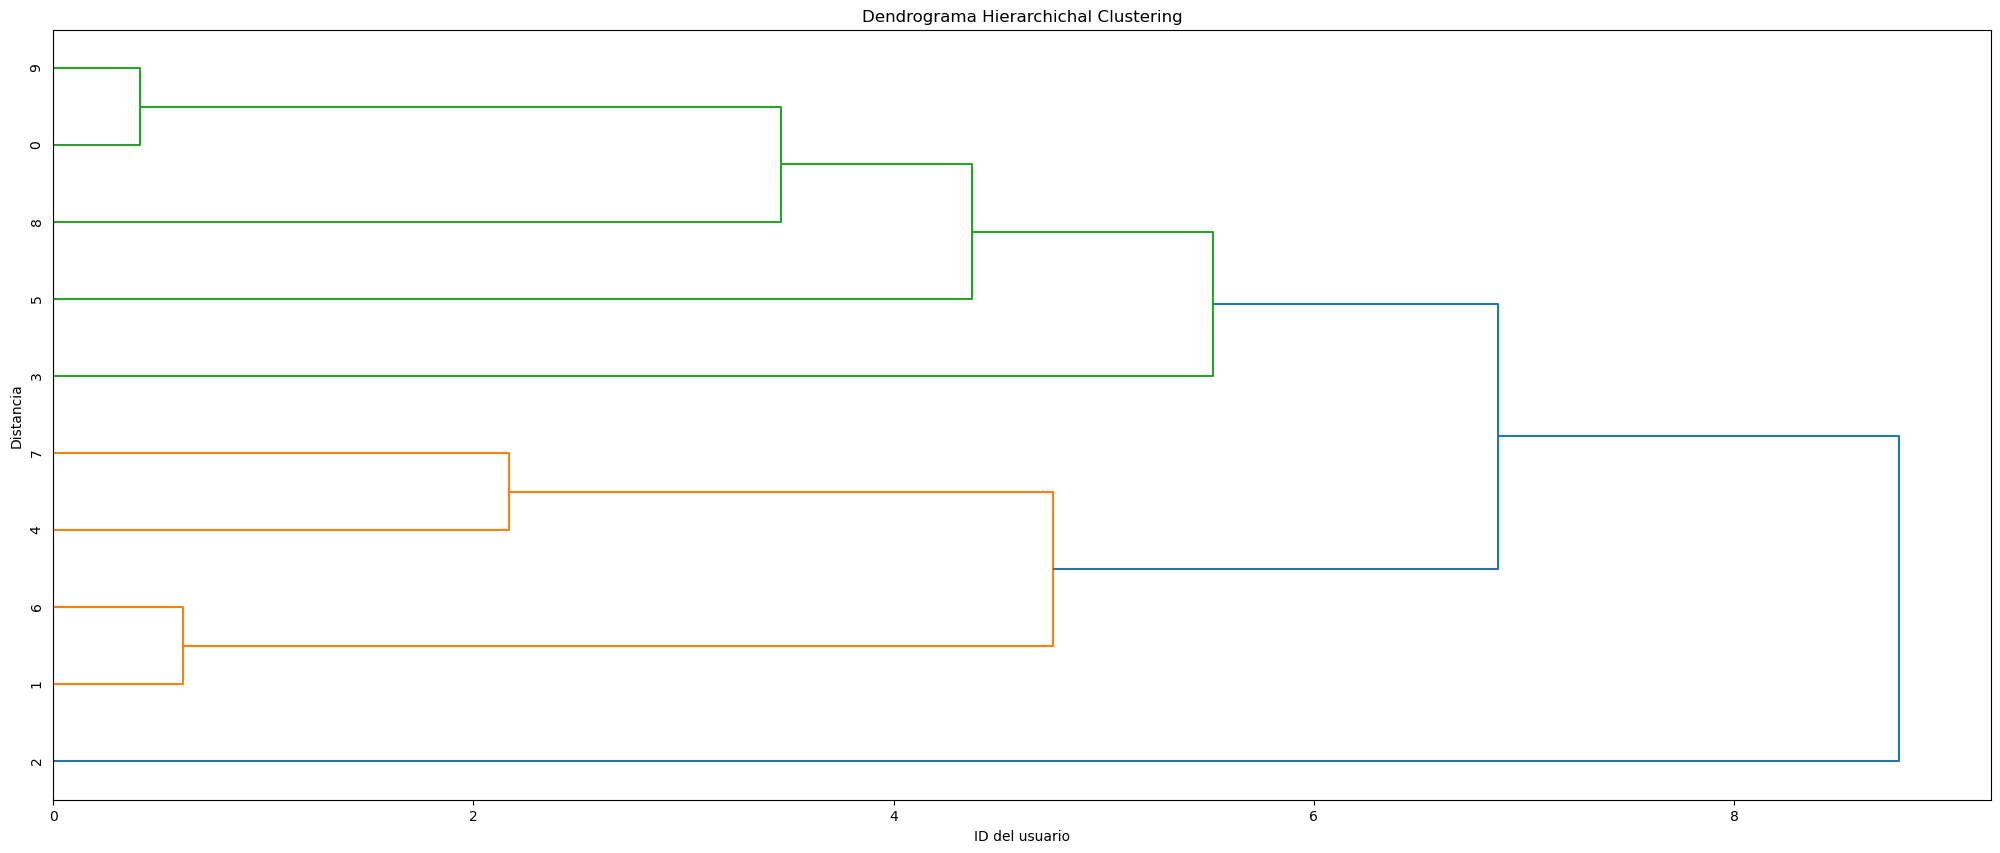

In [124]:
## Comparamos con otro tipo de enlace

Z = linkage(data[movies], "average")

plt.figure(figsize=(25,10)) 
plt.title("Dendrograma Hierarchichal Clustering")
plt.xlabel("ID del usuario")
plt.ylabel("Distancia")
dendrogram(Z, leaf_rotation=90.0,leaf_font_size=10, orientation="right") 
plt.show()

En este enlace promedio, se puede observar que el usuario 2 ha sido agrupado hasta el final, pues tiene valores atípicos, que le ha dado valoraciones "altas" a las películas.

In [125]:
data[movies]

,star_wars,lord_of_the_rings,harry_potter
0,1.2,4.9,2.1
1,2.1,8.1,7.9
2,7.4,3.0,9.9
3,5.6,0.5,1.8
4,1.5,8.3,2.6
5,2.5,3.7,6.5
6,2.0,8.2,8.5
7,1.8,9.3,4.5
8,2.6,1.7,3.1
9,1.5,4.7,2.3


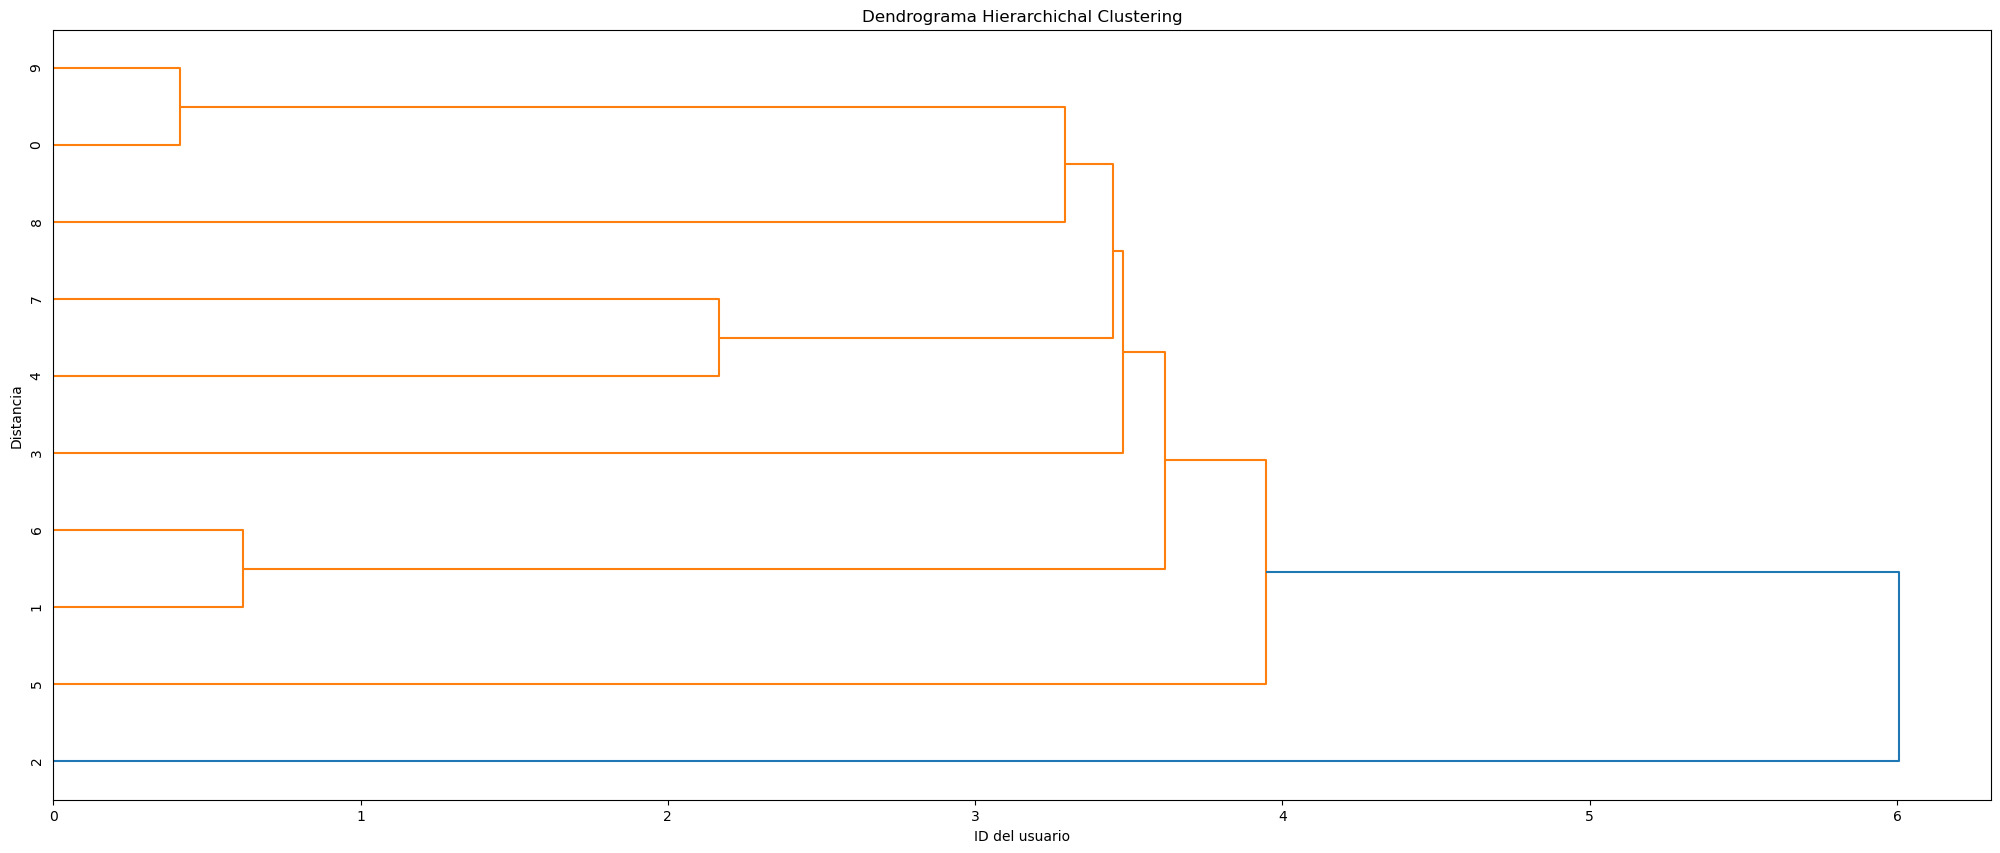

In [126]:
Z = linkage(data[movies], "single")

plt.figure(figsize=(25,10)) 
plt.title("Dendrograma Hierarchichal Clustering")
plt.xlabel("ID del usuario")
plt.ylabel("Distancia")
dendrogram(Z, leaf_rotation=90.0,leaf_font_size=10, orientation="right") 
plt.show()

Se pueden checar otros métodos de enlace en la documentación [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)